# Cell 1 – Markdown
Heart Disease Dataset – Complete Data Preprocessing Notebook

This notebook covers:
- Data Cleaning
- Feature Engineering
- Data Transformation
- Categorical Encoding

The goal is to prepare raw medical data for Machine Learning models.
(Reproduced to match classmate's preprocessing + visualizations)

In [6]:
# Cell 2 – Code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries loaded")

Libraries loaded


In [7]:
# Cell 4 – Code (upload your files here)
from google.colab import files
uploaded = files.upload()   # ← upload the 4 .data files here

Saving heart+disease.zip to heart+disease.zip


# Cell 5 – Markdown
## Data Cleaning & Combining

In [10]:
# Cell: Extract the ZIP file first
import zipfile
import os

zip_path = "/content/heart+disease.zip"           # ← your zip file
extract_path = "/content/heart_disease_raw"       # folder where files will appear

# Create extraction folder if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

try:
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_path)
    print("Dataset extracted successfully!")
    print("Files extracted to:", extract_path)

    # Show what was extracted
    print("\nExtracted files:")
    !ls -l "{extract_path}"
except Exception as e:
    print("Error extracting zip:", e)

Dataset extracted successfully!
Files extracted to: /content/heart_disease_raw

Extracted files:
total 696
-rw-r--r-- 1 root root    587 Jan 30 22:39 ask-detrano
-rw-r--r-- 1 root root   6737 Jan 30 22:39 bak
-rw-r--r-- 1 root root  60669 Jan 30 22:39 cleveland.data
-rw-r--r-- 1 root root  23941 Jan 30 22:39 cleve.mod
drwxr-xr-x 2 root root   4096 Jan 30 22:39 costs
-rw-r--r-- 1 root root  10060 Jan 30 22:39 heart-disease.names
-rw-r--r-- 1 root root  62192 Jan 30 22:39 hungarian.data
-rw-r--r-- 1 root root    644 Jan 30 22:39 Index
-rw-r--r-- 1 root root  39892 Jan 30 22:39 long-beach-va.data
-rw-r--r-- 1 root root 389771 Jan 30 22:39 new.data
-rw-r--r-- 1 root root  18461 Jan 30 22:39 processed.cleveland.data
-rw-r--r-- 1 root root  10263 Jan 30 22:39 processed.hungarian.data
-rw-r--r-- 1 root root   4109 Jan 30 22:39 processed.switzerland.data
-rw-r--r-- 1 root root   6737 Jan 30 22:39 processed.va.data
-rw-r--r-- 1 root root  11058 Jan 30 22:39 reprocessed.hungarian.data
-rw-r--r--

In [11]:
# Cell: Load the four datasets from the extracted folder

import pandas as pd

column_names = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"
]

# IMPORTANT: use the extracted folder path
base_path = "/content/heart_disease_raw"

files_to_load = [
    "processed.cleveland.data",
    "processed.hungarian.data",
    "processed.switzerland.data",
    "processed.va.data"
]

dfs = []

for fname in files_to_load:
    full_path = os.path.join(base_path, fname)
    try:
        df = pd.read_csv(
            full_path,
            header=None,
            names=column_names,
            na_values="?",
            skipinitialspace=True,
            engine='python'
        )
        dfs.append(df)
        print(f"Loaded {fname:25} → {len(df):4} rows")
    except FileNotFoundError:
        print(f"File not found: {full_path}")
    except Exception as e:
        print(f"Error loading {fname}: {e}")

# ────────────────────────────────────────────────
if dfs:
    print("\nCombining all datasets...")
    data = pd.concat(dfs, ignore_index=True)
    print(f"Final shape: {data.shape}")
    display(data.head(8))

    print("\nQuick check - target (num) distribution:")
    print(data['num'].value_counts().sort_index())
else:
    print("\nNo files were loaded. Check the extraction step above.")

Loaded processed.cleveland.data  →  303 rows
Loaded processed.hungarian.data  →  294 rows
Loaded processed.switzerland.data →  123 rows
Loaded processed.va.data         →  200 rows

Combining all datasets...
Final shape: (920, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
6,62.0,0.0,4.0,140.0,268.0,0.0,2.0,160.0,0.0,3.6,3.0,2.0,3.0,3
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0



Quick check - target (num) distribution:
num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64


# Cell 7 – Markdown
## Create binary target + imputation

In [12]:
# Cell 8 – Code
# Binary target: 0 = no disease, 1 = disease (any positive num value)
data["target"] = (data["num"] > 0).astype(int)

# Convert all to numeric and fill missing with median
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

for col in data.select_dtypes(include=np.number).columns:
    if data[col].isna().any():
        data[col] = data[col].fillna(data[col].median())

print("Missing values after imputation:", data.isna().sum().sum())
print("\nTarget distribution:")
print(data["target"].value_counts(normalize=True).mul(100).round(1))

Missing values after imputation: 0

Target distribution:
target
1    55.3
0    44.7
Name: proportion, dtype: float64


# Cell 9 – Markdown
## Save cleaned combined dataset


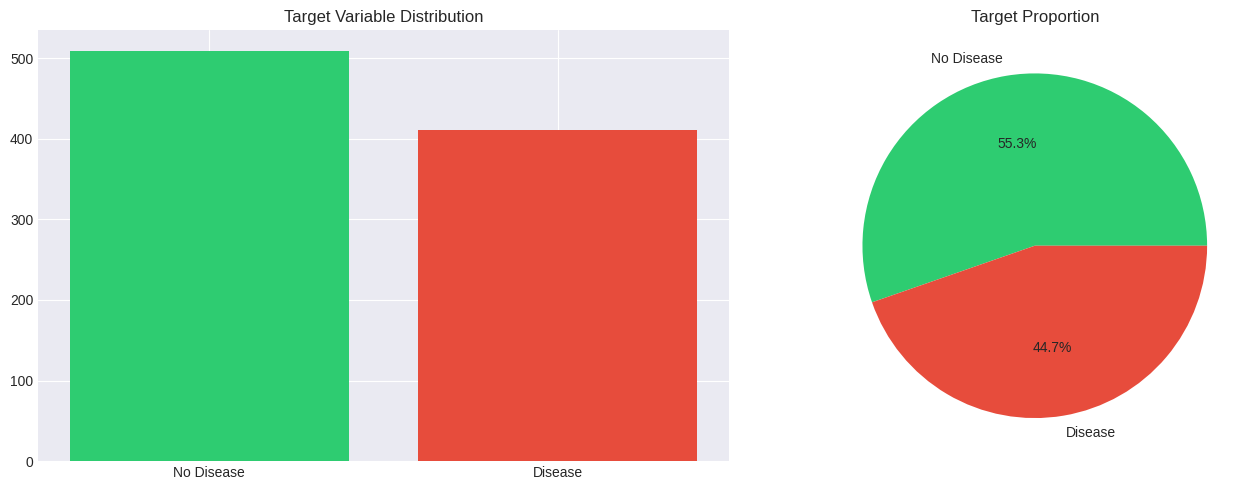

In [13]:
# Cell 12 – Target distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

counts = data['target'].value_counts()
ax1.bar([0,1], counts, color=['#2ecc71', '#e74c3c'])
ax1.set_xticks([0,1])
ax1.set_xticklabels(['No Disease', 'Disease'])
ax1.set_title('Target Variable Distribution')

data['target'].value_counts().plot.pie(
    ax=ax2, autopct='%1.1f%%',
    colors=['#2ecc71', '#e74c3c'],
    labels=['No Disease', 'Disease']
)
ax2.set_title('Target Proportion')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

In [14]:
# Cell 10 – Code
data.to_csv("heart_disease_combined.csv", index=False)
print("Saved: heart_disease_combined.csv")

Saved: heart_disease_combined.csv


# Cell 11 – Markdown
## Visualizations (matching classmate's graphs)


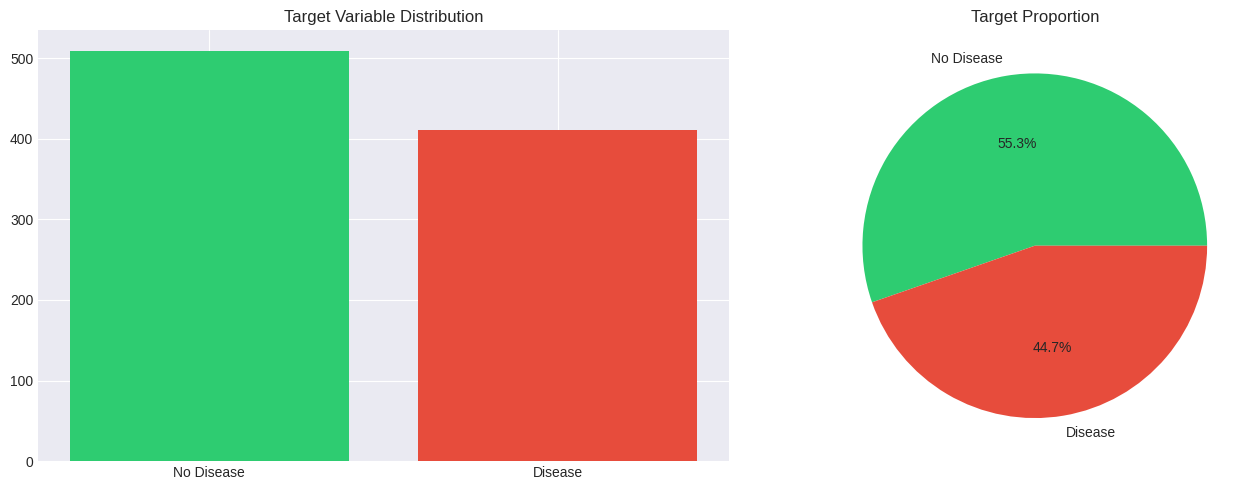

In [15]:
# Cell 12 – Target distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

counts = data['target'].value_counts()
ax1.bar([0,1], counts, color=['#2ecc71', '#e74c3c'])
ax1.set_xticks([0,1])
ax1.set_xticklabels(['No Disease', 'Disease'])
ax1.set_title('Target Variable Distribution')

data['target'].value_counts().plot.pie(
    ax=ax2, autopct='%1.1f%%',
    colors=['#2ecc71', '#e74c3c'],
    labels=['No Disease', 'Disease']
)
ax2.set_title('Target Proportion')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

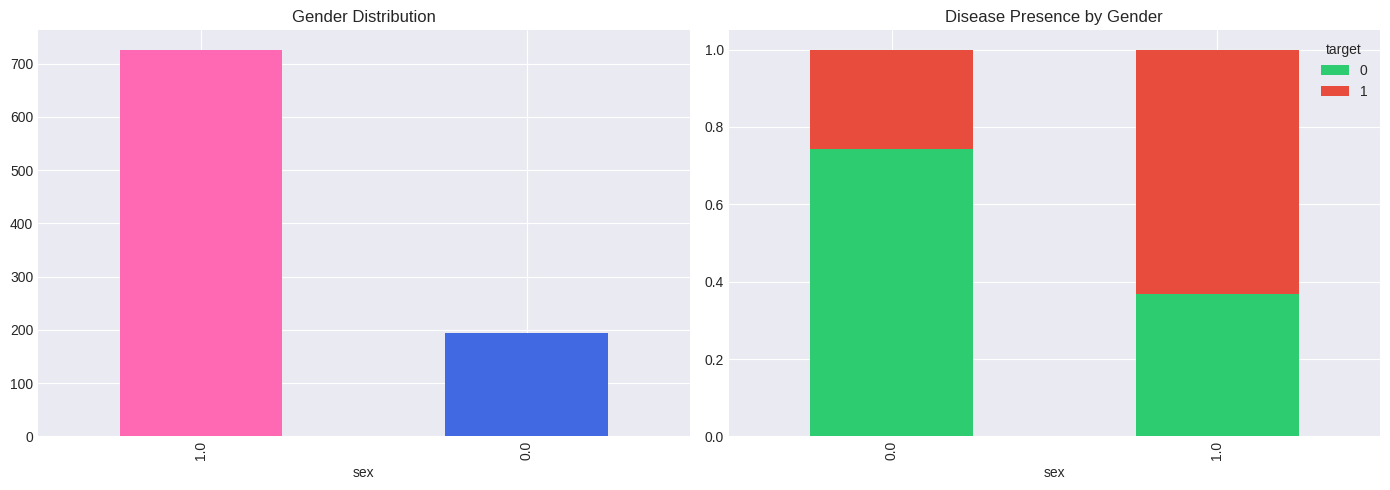

In [16]:
# Cell 13 – Gender
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

data['sex'].value_counts().plot(kind='bar', ax=ax1, color=['#ff69b4','#4169e1'])
ax1.set_title('Gender Distribution')

pd.crosstab(data['sex'], data['target'], normalize='index')\
  .plot(kind='bar', stacked=True, ax=ax2, color=['#2ecc71','#e74c3c'])
ax2.set_title('Disease Presence by Gender')

plt.tight_layout()
plt.show()

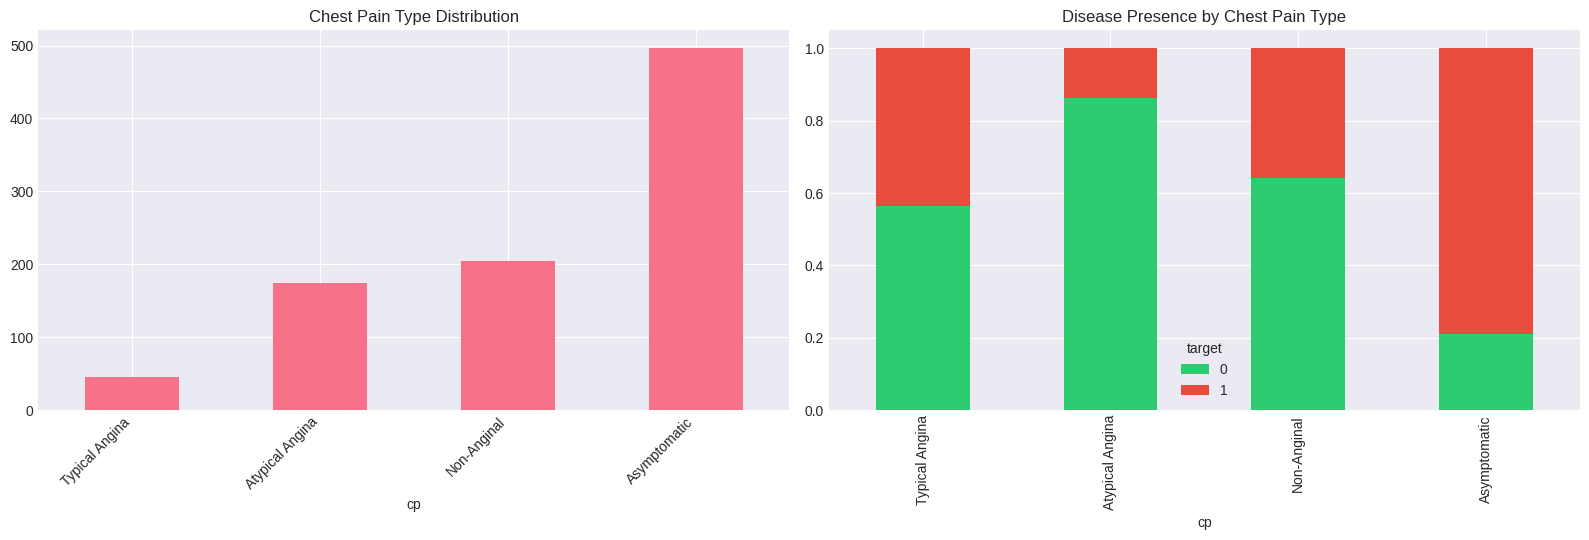

In [17]:
# Cell 14 – Chest pain
cp_labels = {1:'Typical Angina', 2:'Atypical Angina', 3:'Non-Anginal', 4:'Asymptomatic'}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5.5))

data['cp'].value_counts().sort_index().plot(kind='bar', ax=ax1)
ax1.set_xticklabels([cp_labels.get(i,'?') for i in range(1,5)], rotation=45, ha='right')
ax1.set_title('Chest Pain Type Distribution')

pd.crosstab(data['cp'], data['target'], normalize='index')\
  .rename(index=cp_labels)\
  .plot(kind='bar', stacked=True, ax=ax2, color=['#2ecc71','#e74c3c'])
ax2.set_title('Disease Presence by Chest Pain Type')

plt.tight_layout()
plt.show()

/tmp/ipython-input-112459238.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='target', y=col, data=data,
/tmp/ipython-input-112459238.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['No Disease', 'Disease'])
/tmp/ipython-input-112459238.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='target', y=col, data=data,
/tmp/ipython-input-112459238.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['No Disease', 'Disease'])
/tmp/ipython-input-112459238.py:8: F

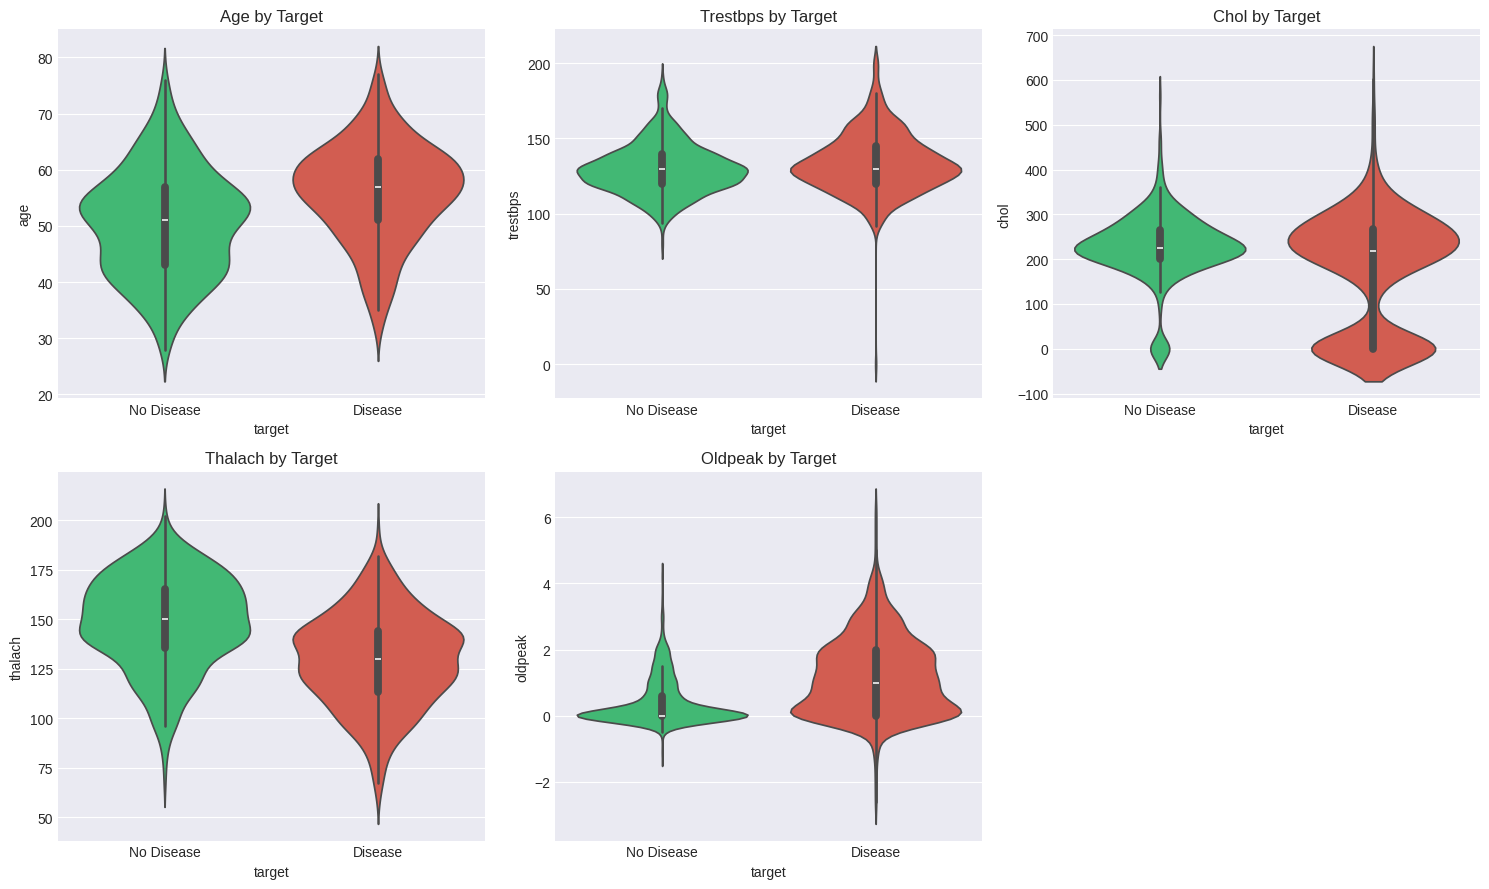

In [18]:
# Cell 15 – Continuous features (violin)
cont = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

fig, axes = plt.subplots(2, 3, figsize=(15, 9))
axes = axes.flat

for i, col in enumerate(cont):
    sns.violinplot(x='target', y=col, data=data,
                   palette=['#2ecc71', '#e74c3c'], ax=axes[i])
    axes[i].set_title(f'{col.title()} by Target')
    axes[i].set_xticklabels(['No Disease', 'Disease'])

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

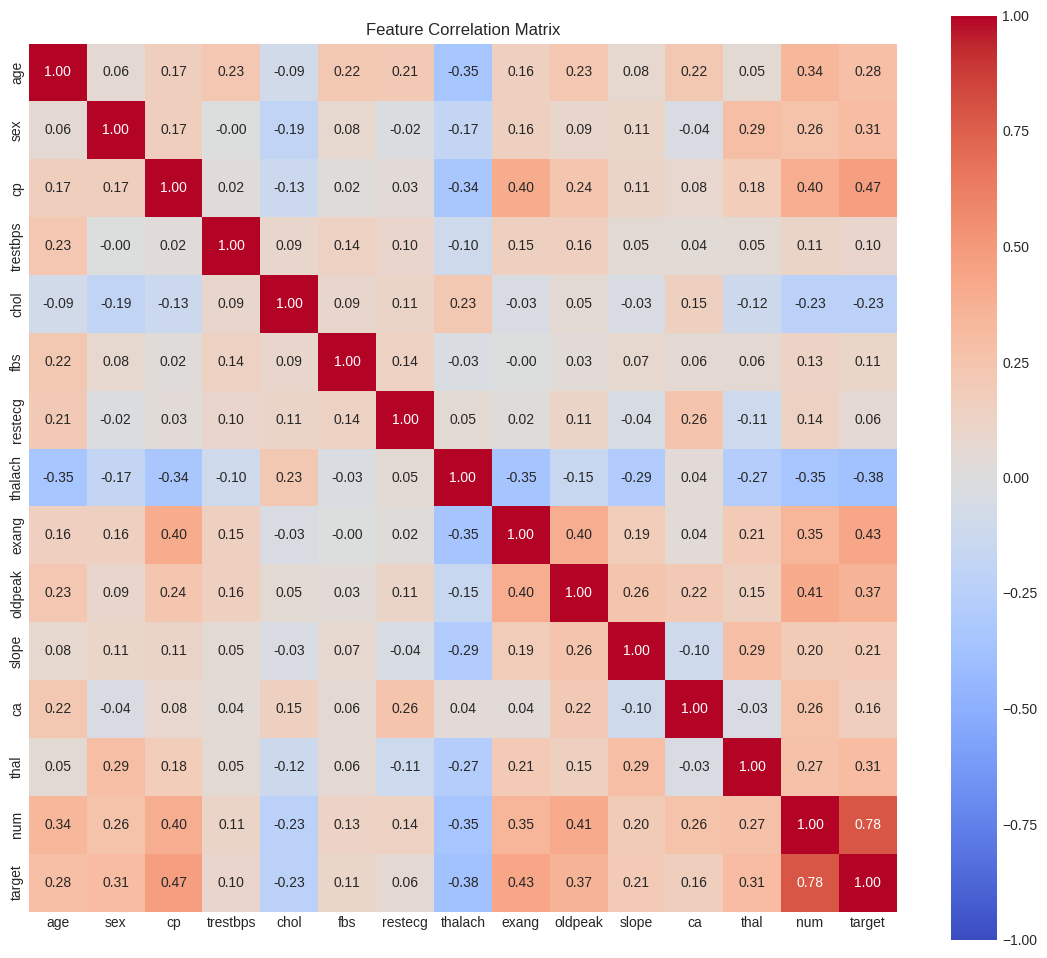

In [19]:
# Cell 16 – Correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    data.select_dtypes(include=np.number).corr(),
    annot=True, fmt='.2f', cmap='coolwarm',
    vmin=-1, vmax=1, center=0, square=True
)
plt.title('Feature Correlation Matrix')
plt.show()